In [1]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import time
import copy
import warnings
from functools import reduce
import datetime

import stanfordnlp
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import numpy as np
import torch as th

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, UNKNOWN_WORD, parsed_reviews_dump_path
from src.review import get_reviews, load_reviews, dump_reviews, reviews_dump_path
from src.preprocess.spell_check import spell_check, load_checked_reviews
from src.preprocess.dep_parse import parse_reviews, load_parsed_reviews, dump_parsed_reviews
from src.polarity.classifier import PolarityClassifier
from src.utils.embedding import get_embeddings

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [2]:
word2vec = get_embeddings()

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/absa/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/absa/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin


In [3]:
# ___________________________Train_______________________________
train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

INFO:root:Upload dependency trees from dump.


In [4]:
# ___________________________Test________________________________
test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:root:Upload dependency trees from dump.


In [ ]:
# preprocess_pipeline(word2vec=word2vec, is_train=True)
# preprocess_pipeline(word2vec=word2vec, is_train=False)

/home/dmitry/.cache/pypoetry/virtualenvs/absa-pCvITjyt-py3.7/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
INFO:root:Number of parameters: 148553
INFO:root:---------------------------------------- Epoch 000 ----------------------------------------
INFO:root:Elapsed time: 4.541 sec
INFO:root:Train      loss: 0.71161| acc: 0.75896
INFO:root:Validation loss: 0.02111| acc: 0.66905| f1_score: 0.26728
INFO:root:---------------------------------------- Epoch 001 ----------------------------------------
INFO:root:Elapsed time: 4.509 sec
INFO:root:Train      loss: 0.63299| acc: 0.75896
INFO:root:Validation loss: 0.01941| acc: 0.66905| f1_score: 0.26728
INFO:root:---------------------------------------- Epoch 002 ----------------------------------------
INFO:root:Elapsed ti

([0.7589623235887096,
  0.7589623235887096,
  0.7592064642137096,
  0.7731461063508065,
  0.7851089969758065],
 [0.6690548780487805,
  0.6690548780487805,
  0.6736280487804878,
  0.7240853658536586,
  0.7423780487804879])

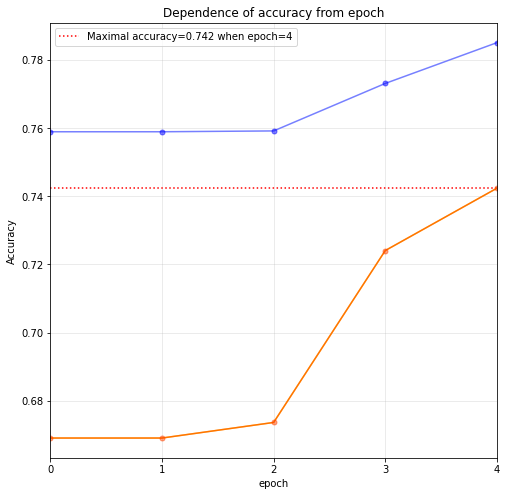

In [5]:
classifier = PolarityClassifier(word2vec=word2vec)
train_hist, val_hist = classifier.fit(train_sentences, test_sentences)

In [8]:
test_sentences_pred = copy.deepcopy(test_sentences)
test_sentences_pred = classifier.predict(test_sentences_pred)

In [ ]:
for sentence in test_sentences_pred[:10]:
    sentence.to_sentence().get_normalized().display()

In [ ]:
for sentence in test_sentences[:10]:
    sentence.to_sentence().get_normalized().display()